# Eager Few Shot Object Detection Colab

Welcome to the Eager Few Shot Object Detection Colab --- in this colab we demonstrate fine tuning of a (TF2 friendly) RetinaNet architecture on very few examples of a novel class after initializing from a pre-trained COCO checkpoint.
Training runs in eager mode.

Estimated time to run through this colab (with GPU): < 5 minutes.

In [1]:
!cd /volume
import os
os.chdir('/volume')

## Imports

In [2]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import Javascript
import IPython
from IPython.display import Image as IPyImage
import util
from util import load_image_into_numpy_array, plot_detections, load_data_dataframe, get_numpy_training_data

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.core.preprocessor import random_horizontal_flip, random_vertical_flip, random_rotation90, random_adjust_brightness, random_adjust_contrast, ssd_random_crop
import object_detection
from object_detection.builders import model_builder

%matplotlib inline

# Utilities

In [3]:
def show_all_boxes():
    for i, image in enumerate(train_images_np):
        boxes = gt_boxes[i]
        for box in boxes:
            print(box)
            plt.plot()
            plt.imshow(image)
            break
        break


# Rubber Ducky data

We will start with some toy (literally) data consisting of 5 images of a rubber
ducky.  Note that the [coco](https://cocodataset.org/#explore) dataset contains a number of animals, but notably, it does *not* contain rubber duckies (or even ducks for that matter), so this is a novel class.

In [4]:
# Load images and visualize
df = load_data_dataframe()

train_images_np, gt_boxes, gt_labels = get_numpy_training_data(df)
df.head()

width  height                      file_name  annotation_id  iscrowd  \
1    977    1303  PXL_20220223_014825675.MP.jpg              0        0   
1    977    1303  PXL_20220223_014825675.MP.jpg              1        0   
1    977    1303  PXL_20220223_014825675.MP.jpg              2        0   
1    977    1303  PXL_20220223_014825675.MP.jpg              3        0   
1    977    1303  PXL_20220223_014825675.MP.jpg              4        0   

   category_id                                       segmentation  \
1            1  [[102.56951400094286, 488.9494064689679, 195.1...   
1            1  [[233.19824856474577, 327.17739743962255, 322....   
1            1  [[330.9535267482539, 174.05629798403896, 249.6...   
1            1  [[455.5266246104236, 189.6279352168102, 367.28...   
1            1  [[566.2582671545744, 234.61266500037146, 661.4...   

                                               bbox          area   color  \
1    [0.37524897, 0.015553047, 0.5279511, 0.199728]  18781.403820   green   
1    [0.25109547, 0.1386315, 0.39516664, 0.3298901]  17539.089095     red   
1  [0.13358119, 0.25551176, 0.26039037, 0.43171757]  14734.526184  purple   
1    [0.1455318, 0.37593383, 0.2763245, 0.55833787]  15511.721270  purple   
1    [0.18005577, 0.48750135, 0.31483203, 0.676989]  16895.480589  purple   

      shape number texture        labels  
1  squiggle    two   solid  [1, 2, 1, 0]  
1      oval    one   solid  [0, 1, 0, 0]  
1      oval    one    open  [2, 1, 0, 2]  
1   diamond  three   solid  [2, 0, 2, 0]  
1      oval    two    open  [2, 1, 1, 2]

In [5]:
def show_all_annotations():
    for _, row in df.iterrows():
        plt.figure(figsize=(4,4))
        plt.title('_'.join([row.color, row['shape'], row.number, row.texture]))
        path = f"data/boxes/box_{row.annotation_id}.png"
        try:
            x = load_image_into_numpy_array(path)
        except Exception:
            continue
        plt.imshow(x)
        # break

# Prepare data for training

Below we add the class annotations (for simplicity, we assume a single class in this colab; though it should be straightforward to extend this to handle multiple classes).  We also convert everything to the format that the training
loop below expects (e.g., everything converted to tensors, classes converted to one-hot representations, etc.).

In [6]:
# By convention, our non-background classes start counting at 1.  Given
# that we will be predicting just one class, we will therefore assign it a
# `class id` of 1.
duck_class_id = 1

category_index = {duck_class_id: {"id": duck_class_id, "name": "card"}}

# Convert class labels to one-hot; convert everything to tensors.
# The `label_id_offset` here shifts all classes by a certain number of indices;
# we do this here so that the model receives one-hot labels where non-background
# classes start counting at the zeroth index.  This is ordinarily just handled
# automatically in our training binaries, but we need to reproduce it here.
label_id_offset = 1
train_image_tensors = []
gt_classes_one_hot_tensors = []
gt_box_tensors = []
for (train_image_np, gt_box_np, gt_multiclass_np) in zip(train_images_np, gt_boxes, gt_labels):
    train_image_tensors.append(
        tf.expand_dims(tf.convert_to_tensor(train_image_np, dtype=tf.float32), axis=0)
    )
    gt_box_tensors.append(tf.convert_to_tensor(gt_box_np, dtype=tf.float32))
    multiclass = tf.reshape(tf.one_hot(gt_multiclass_np, 3, dtype=tf.float32), (gt_box_np.shape[0], -1))
    n_boxes = gt_box_np.shape[0]
    gt_classes_one_hot_tensors.append(
        tf.concat([tf.ones([n_boxes, 1], dtype=tf.float32), multiclass], 1)
    )
print("Done prepping data.")


Done prepping data.


# Let's just visualize the rubber duckies as a sanity check


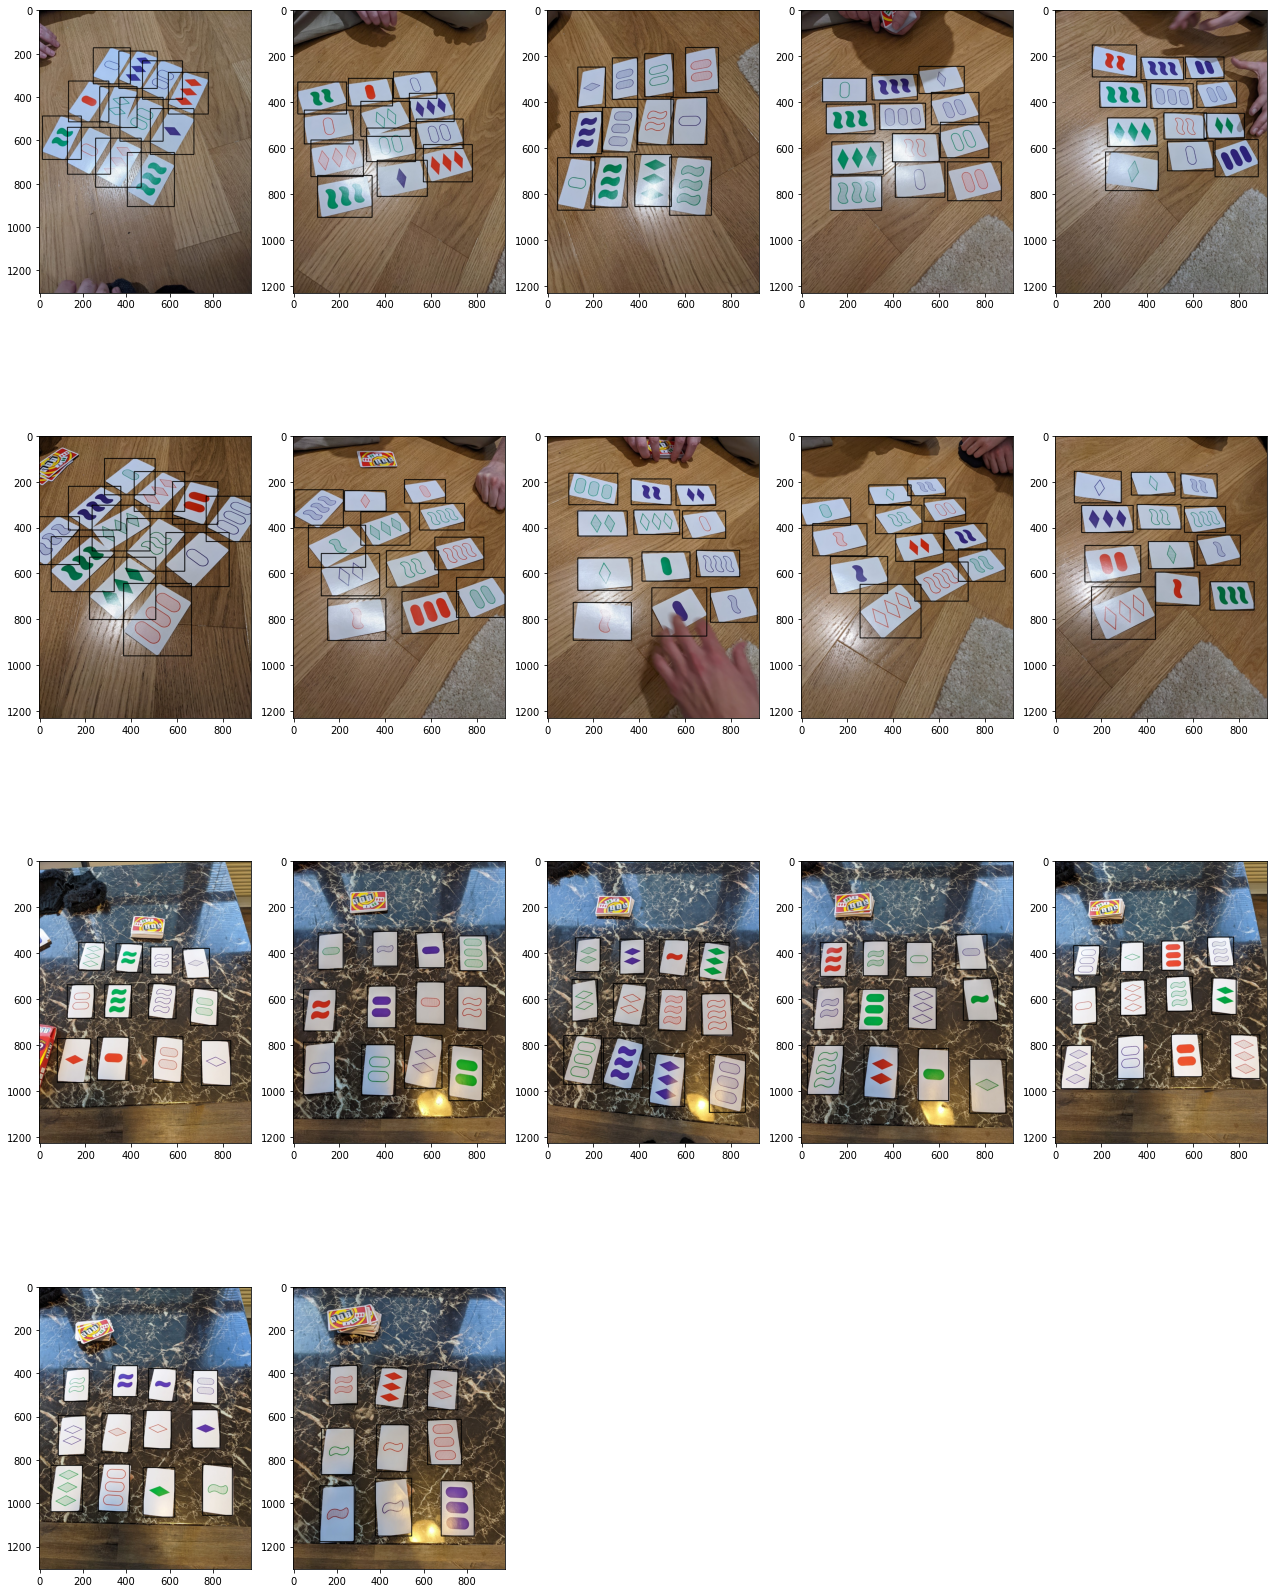

In [7]:
def plot_boxes(images, boxes):
    assert isinstance(images, list)
    assert isinstance(images[0], np.ndarray)
    assert isinstance(boxes, list)
    assert isinstance(boxes[0], np.ndarray)
    fig = plt.figure(figsize=(22, 30))
    assert len(images[0].shape) == 3
    for idx in range(len(images)):
        ax = fig.add_subplot(4, 5, idx + 1)
        plot_detections(
            images[idx],
            boxes[idx],
            np.ones(shape=[boxes[idx].shape[0]], dtype=np.int32),
            None,
            category_index,
            ax=ax,
        )


plot_boxes(train_images_np, gt_boxes)


# Create model and restore weights for all but last layer

In this cell we build a single stage detection architecture (RetinaNet) and restore all but the classification layer at the top (which will be automatically randomly initialized).

For simplicity, we have hardcoded a number of things in this colab for the specific RetinaNet architecture at hand (including assuming that the image size will always be 640x640), however it is not difficult to generalize to other model configurations.

In [8]:
MODEL_NAME = "ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8"
IMAGE_SIZE = (640, 640)
NUM_CLASSES = gt_classes_one_hot_tensors[0].shape[1]
config = util.get_pipeline_config(MODEL_NAME, NUM_CLASSES)
detection_model = util.build_and_restore_model(config["model"], IMAGE_SIZE)


Building model and restoring weights for fine-tuning...
Weights restored!


# Eager mode custom training loop



In [9]:
import random
import cv2


def random_rotate_image(image, boxes):
    assert len(image.shape) == 3
    angle = random.randint(-15, 15)
    image = image.numpy()
    height, width = image.shape[:2]
    image_center = (width / 2, height / 2)
    box_scale = np.array([width, height])[np.newaxis]
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)

    def transform(boxes):
        boxes = tf.reshape(boxes, (-1, 2))
        boxes = tf.stack([boxes[:, 1], boxes[:, 0]], 1)
        boxes *= box_scale
        # boxes = tf.pad(boxes, [[0, 1], [0, 0]], "constant", 1.0)
        return boxes

    def inverse(boxes):
        boxes /= box_scale
        boxes = tf.stack([boxes[:, 1], boxes[:, 0]], 1)
        boxes = tf.reshape(boxes, (-1, 4))
        return boxes

    boxes = transform(boxes)
    boxes = boxes.numpy()
    boxes = np.expand_dims(boxes, 1)
    boxes = cv2.transform(boxes, rot_mat)
    boxes = boxes.squeeze()
    boxes = inverse(boxes)
    return tf.convert_to_tensor(result), boxes


def random_blur(image, max_num_blurs=5):
    image = image.numpy()
    for i in range(random.randint(0, max_num_blurs)):
        image = cv2.GaussianBlur(image, [3, 3], 0)
    return image


def random_crop_image(im, boxes, classes, weights):
    assert len(im.shape) == 3, im.shape
    (
        im,
        boxes,
        classes,
        weights,
    ) = object_detection.core.preprocessor.random_crop_image(
        im, boxes, classes, weights
    )
    return im, boxes, classes, weights


# TODO update this to handle boxes that are already rotated
# i, boxes = random_rotate_image(train_image_tensors[0][0], gt_boxes[0])
# i = tf.cast(i, tf.uint8).numpy()
# plot_boxes([i], [boxes.numpy()])


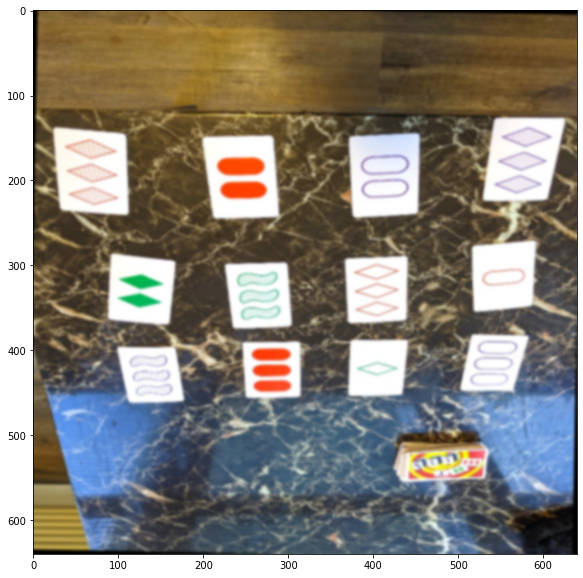

In [10]:
def data_gen(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors):
    aug_image_tensors = list(train_image_tensors)
    aug_box_tensors = list(gt_box_tensors)
    aug_classes_one_hot_tensors = list(gt_classes_one_hot_tensors)
    for i, image in enumerate(aug_image_tensors):
        image = image[0]
        image = tf.image.resize(image, IMAGE_SIZE)
        # Apply series of augmentations
        image = random_adjust_brightness(
            image,
            max_delta=0.1,
        )
        image = object_detection.core.preprocessor.random_adjust_saturation(image, 0.7, 1.3)
        image = object_detection.core.preprocessor.random_adjust_hue(image, 0.1)
        image = random_adjust_contrast(
            image,
            min_delta=0.8,
            max_delta=1.3,
        )
        # image, aug_box_tensors[i], aug_classes_one_hot_tensors[i], _ = random_crop_image(image, aug_box_tensors[i], aug_classes_one_hot_tensors[i], aug_classes_one_hot_tensors[i])
        image, aug_box_tensors[i] = random_horizontal_flip(image, aug_box_tensors[i])
        image, aug_box_tensors[i] = random_vertical_flip(image, aug_box_tensors[i])
        image, aug_box_tensors[i] = random_rotation90(image, aug_box_tensors[i])
        image, aug_box_tensors[i] = random_rotate_image(image, aug_box_tensors[i])
        image = random_blur(image)
        # image = object_detection.core.preprocessor.random_patch_gaussian(image)
        image = tf.expand_dims(image, 0)
        aug_image_tensors[i] = image
    return aug_image_tensors, aug_box_tensors, aug_classes_one_hot_tensors


def plot_augments():
    aug_images = data_gen(
        train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors
    )[0][-3:-2]
    for im in aug_images:
        im = tf.cast(im[0], tf.uint8)
        plt.figure(figsize=(10, 10))
        plt.imshow(im)


plot_augments()


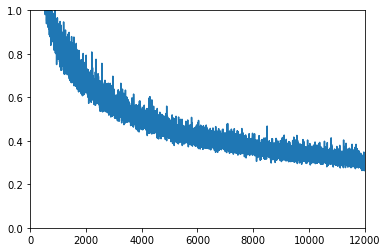

batch 11991 of 12000, loss=0.2956126928329468
Done fine-tuning!


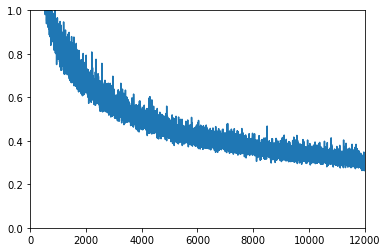

In [11]:
def train(detection_model):
    tf.keras.backend.set_learning_phase(True)

    # These parameters can be tuned; since our training set has 5 images
    # it doesn't make sense to have a much larger batch size, though we could
    # fit more examples in memory if we wanted to.
    batch_size = len(train_images_np)
    num_batches = 12_000

    # Select variables in top layers to fine-tune.
    trainable_variables = detection_model.trainable_variables
    to_fine_tune = []
    prefixes_to_train = [
        "WeightSharedConvolutionalBoxPredictor",
        "ssd_mobile_net_v2_fpn_keras_feature_extractor",
    ]
    for var in trainable_variables:
        if any([var.name.startswith(prefix) for prefix in prefixes_to_train]):
            to_fine_tune.append(var)
    # print("Tuning", [v.name for v in to_fine_tune])

    # to_fine_tune = trainable_variables  # Fine tune everything

    # Set up forward + backward pass for a single train step.
    def get_model_train_step_function(model, optimizer, vars_to_fine_tune):
        """Get a tf.function for training step."""

        # Use tf.function for a bit of speed.
        # Comment out the tf.function decorator if you want the inside of the
        # function to run eagerly.
        @tf.function
        def train_step_fn(
            image_tensors, groundtruth_boxes_list, groundtruth_classes_list
        ):
            """A single training iteration.

            Args:
              image_tensors: A list of [1, height, width, 3] Tensor of type tf.float32.
                Note that the height and width can vary across images, as they are
                reshaped within this function to be 640x640.
              groundtruth_boxes_list: A list of Tensors of shape [N_i, 4] with type
                tf.float32 representing groundtruth boxes for each image in the batch.
              groundtruth_classes_list: A list of Tensors of shape [N_i, num_classes]
                with type tf.float32 representing groundtruth boxes for each image in
                the batch.

            Returns:
              A scalar tensor representing the total loss for the input batch.
            """
            shapes = tf.constant(batch_size * [[*IMAGE_SIZE, 3]], dtype=tf.int32)
            model.provide_groundtruth(
                groundtruth_boxes_list=groundtruth_boxes_list,
                groundtruth_classes_list=groundtruth_classes_list,
            )
            with tf.GradientTape() as tape:
                preprocessed_images = tf.concat(
                    [
                        detection_model.preprocess(image_tensor)[0]
                        for image_tensor in image_tensors
                    ],
                    axis=0,
                )
                prediction_dict = model.predict(preprocessed_images, shapes)
                losses_dict = model.loss(prediction_dict, shapes)
                total_loss = (
                    losses_dict["Loss/localization_loss"]
                    + losses_dict["Loss/classification_loss"]
                )
                gradients = tape.gradient(total_loss, vars_to_fine_tune)
                optimizer.apply_gradients(zip(gradients, vars_to_fine_tune))
            return total_loss

        return train_step_fn

    lr_schedule = tf.keras.optimizers.schedules.PiecewiseConstantDecay(
        [300, 800, num_batches-200],
        [.01, 0.01, 0.01, 0.003],
    )

    optimizer = tf.keras.optimizers.SGD(
        learning_rate=lr_schedule, momentum=0.9, nesterov=True
    )
    train_step_fn = get_model_train_step_function(
        detection_model, optimizer, to_fine_tune
    )

    print("Start fine-tuning!", flush=True)

    losses = []
    fig, ax = plt.subplots()
    for idx in range(num_batches):
        # Apply augmentations
        aug_image_tensors, aug_box_tensors, aug_classes_one_hot_tensors = data_gen(train_image_tensors, gt_box_tensors, gt_classes_one_hot_tensors)

        # plot_boxes([n.numpy().astype(np.uint8)[0] for n in aug_image_tensors], [n.numpy() for n in aug_box_tensors])
        total_loss = train_step_fn(
            aug_image_tensors, aug_box_tensors, aug_classes_one_hot_tensors
        )
        assert not tf.math.is_nan(total_loss)
        losses.append(total_loss)

        if idx % 10 == 0:
            # plt.clf()
            IPython.display.clear_output(wait=True)
            ax.clear()
            ax.plot(losses)
            ax.set_xlim(0, num_batches)
            ax.set_ylim(0, 1)
            fig.patch.set_alpha(1)
            IPython.display.display(fig)
            print(f"batch {idx+1} of {num_batches}, loss={total_loss.numpy()}")

    print("Done fine-tuning!")


train(detection_model)
# TODO try training longer


# Load test images and run inference with new model!

In [12]:
def get_labels_from_multiclass_score(multiclass_score):
    multiclass_score = multiclass_score[2:]  # Remove background and base (card) class
    multiclass_score = tf.reshape(multiclass_score, (4, 3))
    multiclass_score = tf.math.argmax(multiclass_score, 1)
    labels = []
    for i, label_list in enumerate(util.LABELS.values()):
        labels.append(label_list[multiclass_score[i]])

    return labels


data/PXL_20220223_015905189.MP.jpg
{'detection_boxes': TensorShape([25, 4]), 'detection_scores': TensorShape([25]), 'detection_classes': TensorShape([25]), 'num_detections': TensorShape([1]), 'raw_detection_boxes': TensorShape([1, 51150, 4]), 'raw_detection_scores': TensorShape([1, 51150, 14]), 'detection_multiclass_scores': TensorShape([25, 14]), 'detection_anchor_indices': TensorShape([25])}


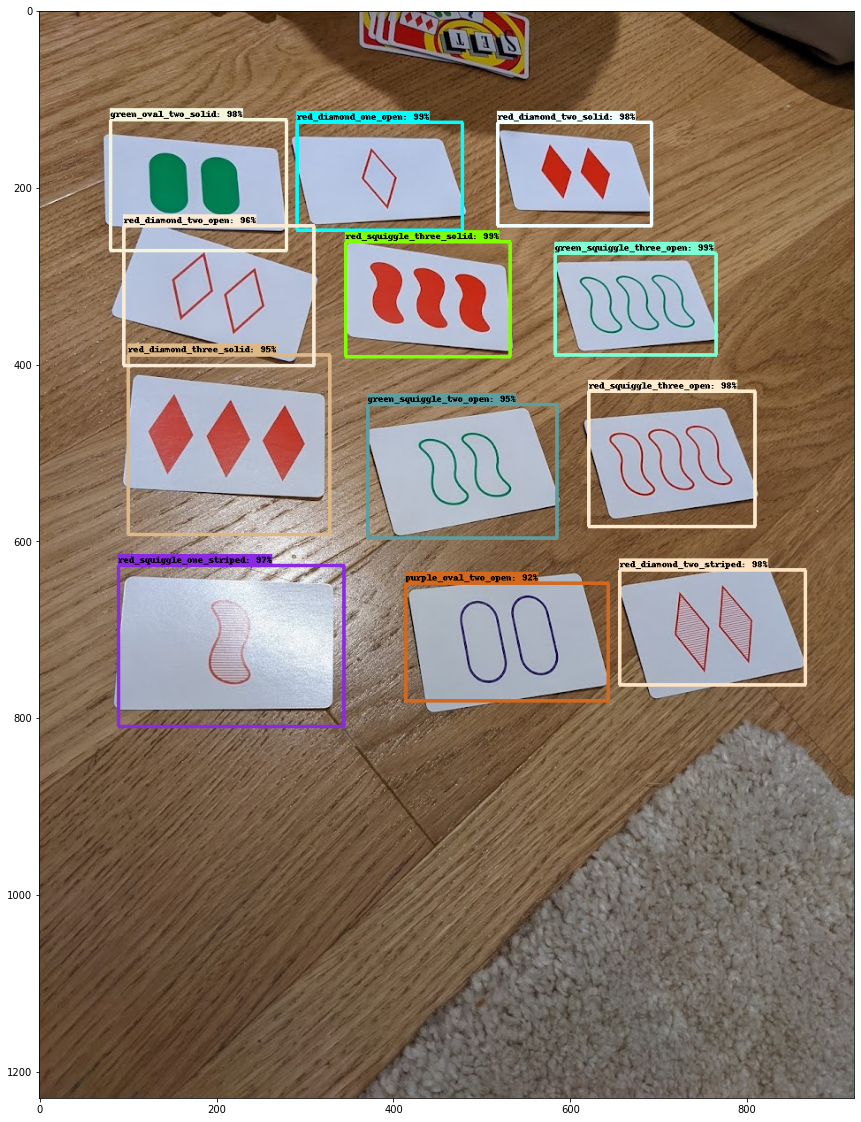

In [13]:
def eval(detection_model):
    # TODO abstract data loading into function
    test_image_dir = "data/"
    test_images_np = []
    for file in ["PXL_20220223_015905189.MP.jpg"]:  # TODO extract constant
        path = os.path.join(test_image_dir, file)
        if not os.path.isfile(path):
            continue
        # if not file.startswith("PXL"):
            # continue
        print(path)
        test_images_np.append(np.expand_dims(load_image_into_numpy_array(path), axis=0))

    # Again, uncomment this decorator if you want to run inference eagerly
    @tf.function
    def detect(input_tensor):
        """Run detection on an input image.

        Args:
          input_tensor: A [1, height, width, 3] Tensor of type tf.float32.
            Note that height and width can be anything since the image will be
            immediately resized according to the needs of the model within this
            function.

        Returns:
          A dict containing 3 Tensors (`detection_boxes`, `detection_classes`,
            and `detection_scores`).
        """
        preprocessed_image, shapes = detection_model.preprocess(input_tensor)
        prediction_dict = detection_model.predict(preprocessed_image, shapes)
        return detection_model.postprocess(prediction_dict, shapes)

    # Note that the first frame will trigger tracing of the tf.function, which will
    # take some time, after which inference should be fast.

    def nms(prediction_dict):
        """Apply non-max suppression over the first image in batch, ignoring classes"""
        boxes = prediction_dict["detection_boxes"][0]
        scores = tf.transpose(prediction_dict["detection_multiclass_scores"][0])[1]
        selected = tf.image.non_max_suppression(boxes, scores, 26, 0.4)
        for k,v in prediction_dict.items():
            if not k.startswith("detection"):
                continue
            prediction_dict[k] = tf.gather(v[0], selected)

    label_id_offset = 1
    for i in range(len(test_images_np)):
        input_tensor = tf.convert_to_tensor(test_images_np[i], dtype=tf.float32)
        detections = detect(input_tensor)
        nms(detections)

        print({k: v.shape for k, v in detections.items()})
        n_boxes = detections["detection_boxes"].shape[0]

        classes = []
        category_index = {}
        for d in detections["detection_multiclass_scores"]:
            classes.append('_'.join(get_labels_from_multiclass_score(d)))
            category_index[len(classes)]= {"id": len(classes), "name": classes[-1]}


        plot_detections(
            test_images_np[i][0],
            detections["detection_boxes"].numpy(),
            # detections["detection_classes"].numpy().astype(np.uint32)
            # + label_id_offset,
            range(1, n_boxes+1),
            detections["detection_scores"].numpy(),
            category_index,
            figsize=(25, 20),
            # image_name="gif_frame_" + ('%02d' % i) + ".jpg"
        )
        # break


eval(detection_model)

# Export the model

In [14]:
import object_detection.exporter_lib_v2

CHECKPOINT_DIR = "checkpoints/"
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.save(CHECKPOINT_DIR)


pipeline_config = util.get_pipeline_config(MODEL_NAME, NUM_CLASSES)
pipeline_config = object_detection.utils.config_util.create_pipeline_proto_from_configs(
    pipeline_config
)

object_detection.exporter_lib_v2.export_inference_graph(
    "image_tensor",
    pipeline_config,
    CHECKPOINT_DIR,
    "exports/",
)


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))


INFO:tensorflow:Assets written to: exports/saved_model/assets


INFO:tensorflow:Assets written to: exports/saved_model/assets


INFO:tensorflow:Writing pipeline config file to exports/pipeline.config


INFO:tensorflow:Writing pipeline config file to exports/pipeline.config


In [15]:
import tensorflow as tf
tf.keras.backend.clear_session()
model = tf.saved_model.load(f'exports/saved_model')

In [16]:
output_dict = model.signatures['serving_default'](input_tensor=tf.cast(train_image_tensors[-1], tf.uint8))

In [ ]:
!pipenv run tensorflowjs_converter  --quantize_float16 --input_format=tf_saved_model --saved_model_tags serve --signature_name serving_default exports/saved_model web_model